In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)  # Numpy module.
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
# random.seed(seed)  # Python random module.
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

In [2]:
transform = torchvision.transforms.ToTensor()
train_set = torchvision.datasets.MNIST(root="../.data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root="../.data", train=False, download=True, transform=transform)

In [3]:
len(train_set)

60000

In [4]:
train_set.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [5]:
train_set.targets.bincount()

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=2)

In [7]:
def show_batch(batch):
    plt.figure(figsize=(50,50))
    images, labels = batch
    for i, image in enumerate(images):
        plt.subplot(10,10,i+1)
        plt.imshow(image.reshape(28,28), cmap='gray')
        plt.axis('off')
        plt.title(f"Label: {labels[i]}", fontsize=28)
    plt.show()

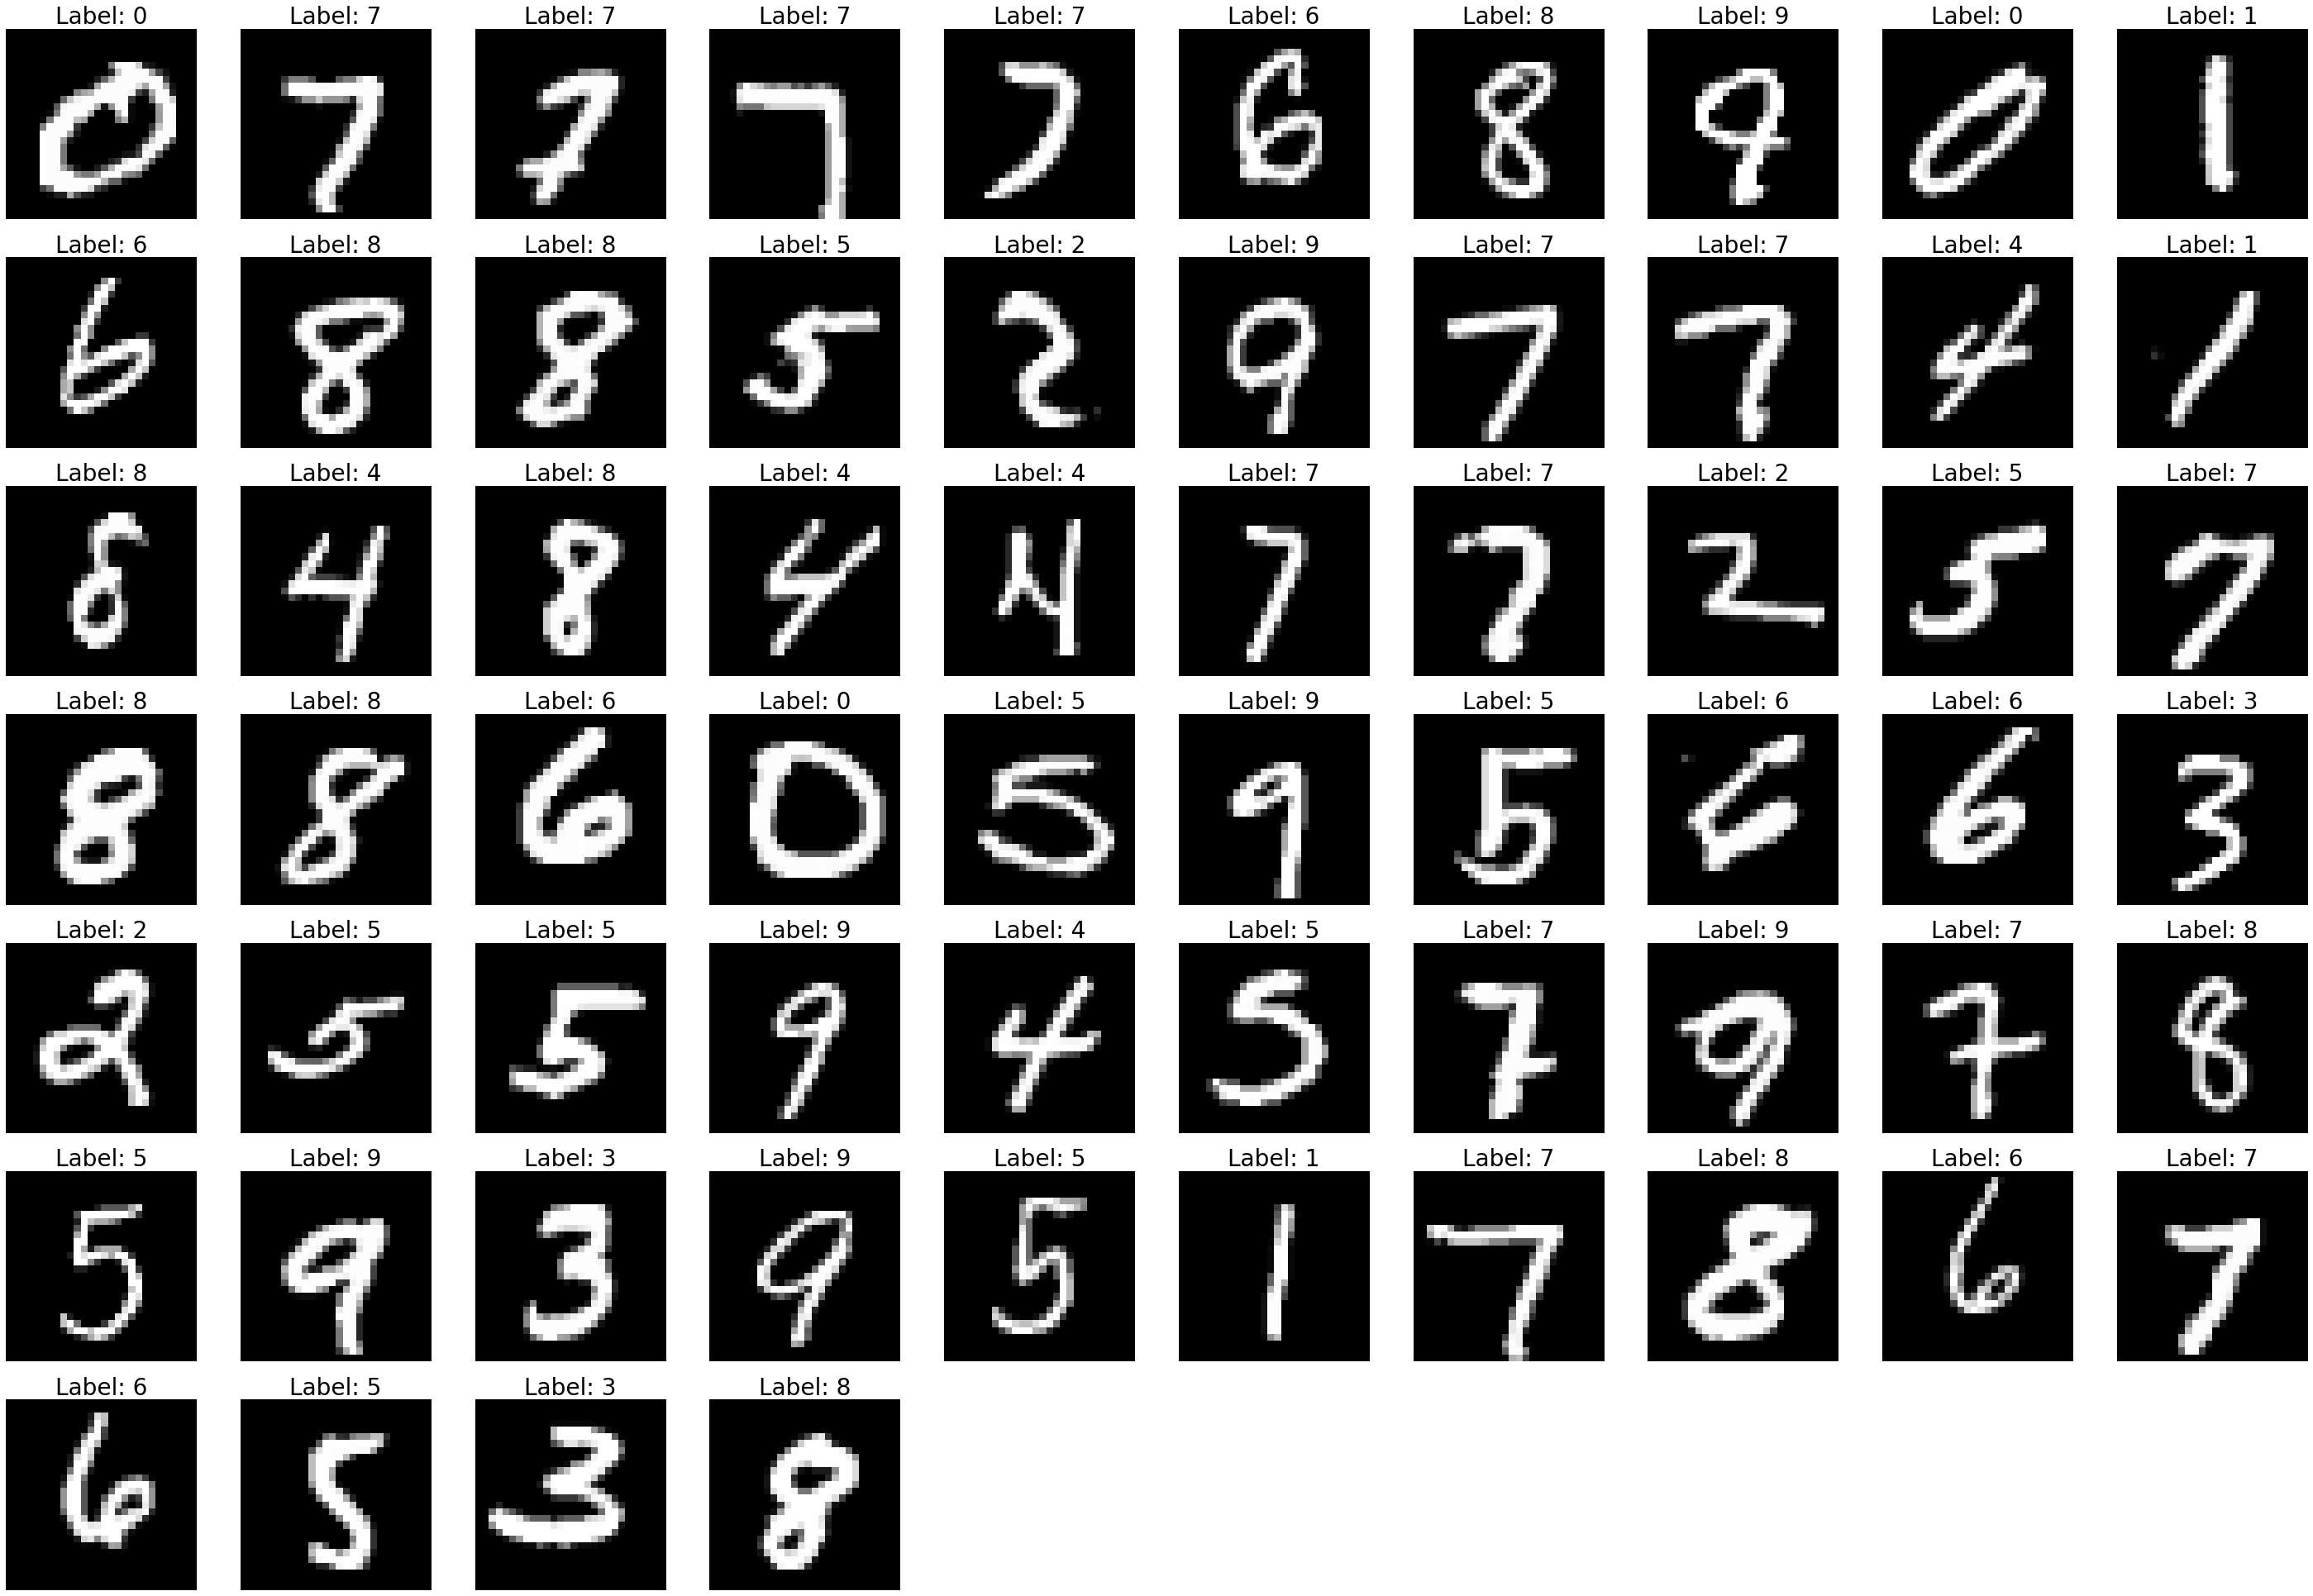

In [8]:
batch = iter(train_loader).next()
show_batch(batch)

In [9]:
class DigitRecognizer(nn.Module):
    def __init__(self):
        super(DigitRecognizer, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Linear(400, 120)
        self.layer4 = nn.Linear(120, 84)
        self.layer5 = nn.Linear(84, 10)
        
    
    def forward(self, X):
        X = self.layer1(X)
        X = self.layer2(X)
        
        X = X.flatten(1)
        
        X = F.relu(self.layer3(X))
        X = F.relu(self.layer4(X))
        
        X = F.softmax(self.layer5(X), dim=1)
        
        return X

model = DigitRecognizer()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
print(model)

DigitRecognizer(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Linear(in_features=400, out_features=120, bias=True)
  (layer4): Linear(in_features=120, out_features=84, bias=True)
  (layer5): Linear(in_features=84, out_features=10, bias=True)
)


In [10]:
def one_epoch(model, optimizer, criterion, loader):
    print("Training ==> Batch: ", end=" ")
    running_loss = 0

    for idx, data in enumerate(loader, start=1):
        images, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if idx % 100 == 0:
            print(idx, end=" ")

    return running_loss / len(loader)

In [11]:
def validate(model, criterion, loader):
    print("\nValidation ==> Batch: ", end=" ")
    running_loss = 0
    
    for idx, data in enumerate(loader, start=1):
        images, labels = data
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        
        if idx % 50 == 0:
            print(idx, end=" ")
    
    return running_loss / len(loader)

In [12]:
def train(model, optimizer, criterion, train_loader, val_loader, num_of_epochs):
    for epoch in range(1, num_of_epochs+1):
        print(f"EPOCH {epoch}")

        model.train()
        avg_train_loss = one_epoch(model, optimizer, criterion, train_loader)

        model.eval()
        avg_val_loss = validate(model, criterion, val_loader)
        
        print()
        print(f"Average Loss ==> Train: {avg_train_loss} \t Validation: {avg_val_loss}", end="\n\n")

In [13]:
EPOCHS = 2
train(model, optimizer, criterion, train_loader, test_loader, EPOCHS)

EPOCH 1
Training ==> Batch:  100 200 300 400 500 600 700 800 900 
Validation ==> Batch:  50 100 150 
Average Loss ==> Train: 1.6484539975235457 	 Validation: 1.5023227846546539

EPOCH 2
Training ==> Batch:  100 200 300 400 500 600 700 800 900 
Validation ==> Batch:  50 100 150 
Average Loss ==> Train: 1.498345757979574 	 Validation: 1.492037090526265



In [14]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 

In [15]:
check_accuracy(train_loader, model)

Got 58084 / 60000 with accuracy 96.81


In [16]:
check_accuracy(test_loader, model)

Got 9702 / 10000 with accuracy 97.02
